In [3]:
import skorch
from datajoint_tables import *
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
from matplotlib import gridspec
import warnings
warnings.filterwarnings('ignore')
from plotting import *

Connecting langdon@pioneer.cshl.edu:3306


## Outline

### I. Circuit Mechanisms in Large RNNs

* #### Circuit mechanisms in small models 
    * Hand tuned circuits (Ardid et al.)
    * Small circuits via backpropagation appear to show a large variety of solutions. An understanding of these mechanisms is important for developing expectations for latent circuits.
       
* #### Latent circuits in large models
    * A latent circuit of $\mathcal{M}$ is a pair $(\bar{\mathcal{M}}, Q)$ such that $\bar{\mathcal{M}} \overset{Q}{\to} \mathcal{M}$
        * **Figure One** Schematic
    * Interpretation: $Q^TW_\text{rec}Q = \bar{W}_\text{rec} \text{ and } Q^T W_\text{in} = \bar{W}_\text{in}$  
    * Sloppiness and validation:
        * **Figure Two:** Inferring embedded circuit: accuracy vs. validation loss plot
    * Application: Context-dependent decision-making
        * **Figure Three:** Adjacency and psychometrics.
        * **Figure Four:** Latent circuit
            * Panel A: Latent adjacency
            * Panel B: Q
            * Trajectories and fits
        * **Figure Five** Perturbations
        * **Figure Six:** Correlation between $(W_\text{in}| W_\text{out})^T$ and $Q$. 
        * **Figure Seven:** Correlations in $W_\text{ext}$
    
### II. What insight is gained about circuit mechanisms from common dimensionality reduction methods?
* **Figure Seven:** Multi-area RNN model
* **Figure Eight:** Comparison of LCA, LDA and dPCA and linear regression.

### III. Supplementary Figures
* **Supplementary Figure One**
    * Scatter plot fits



# Figure Two
* Train a small model
* Embed trajectories with random orthogonal Q
* Apply LCA

In [8]:
df = pd.DataFrame((Model() & 'connectivity="small"' & 'lr=.001').proj('model_id', 'connectivity','lr','r2','l2_task').fetch())
df.sort_values(by=['l2_task'],ascending=True).head(5)

model_id connectivity        lr        r2   l2_task
16  jC6v1aS0        small  0.001000  0.941931  0.009076
0   1rKbjkPP        small  0.001000  0.937182  0.009818
3   7N1SZMJ8        small  0.001000  0.936579  0.009912
9   fdtFi2Nw        small  0.001000  0.935983  0.010005
18  KWuBKs1M        small  0.001000  0.933558  0.010384

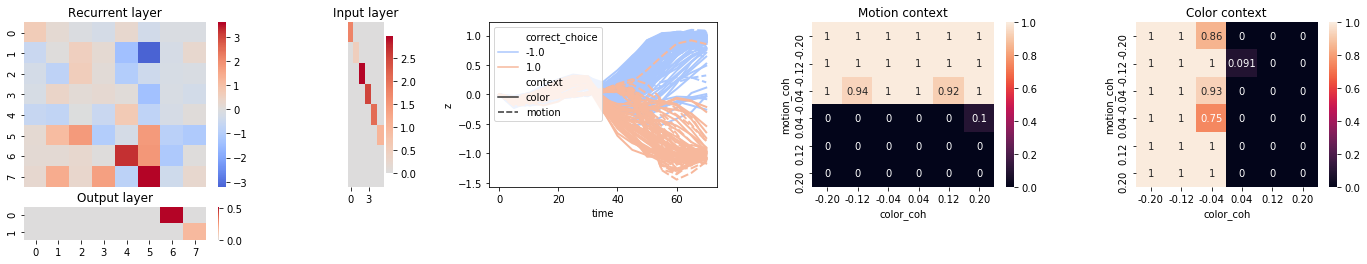

In [4]:
plot_figure_three(Model(), "fdtFi2Nw",Trial() & 'model_id="fdtFi2Nw"')

In [5]:
LCA() & 'model_id="fdtFi2Nw"'

*model_id    *lca_id    lr     max_epochs     valid_loss     valid_loss train_loss w_rec      w_in       w_out      q          w_error     q_error    
+----------+ +--------+ +----+ +------------+ +------------+ +--------+ +--------+ +--------+ +--------+ +--------+ +--------+ +---------+ +---------+

 (Total: 0)

# Figure Three
* Train a large RNN model
* Plot adjacency 
* Psychometrics

Text(0.5, 1, 'Color context')

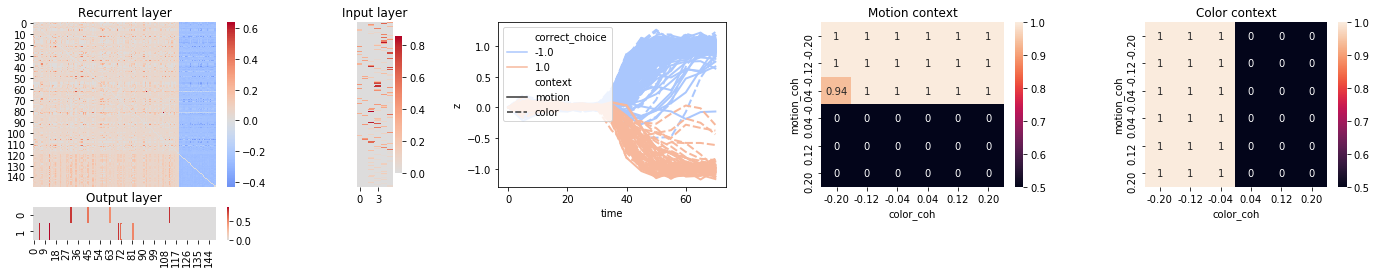

In [16]:
model_table = Model()
model_id = "6rV5JuQH"
trial_table = Trial() & 'model_id="6rV5JuQH"'
gs = gridspec.GridSpec(2, 5, width_ratios=[5,1, 5, 5, 5],height_ratios=[5, 1],wspace=.5) 
plt.figure(figsize=(24, 4)) 

# Recurrent matrix
plt.subplot(gs[0])
sns.heatmap((model_table & {'model_id':  model_id}).fetch1('w_rec'), center=0, xticklabels=False, cmap='coolwarm')
plt.title('Recurrent layer')

# Input matrix
plt.subplot(gs[1])
sns.heatmap((model_table & {'model_id':  model_id}).fetch1('w_in'), center=0, yticklabels=False, cmap='coolwarm')
plt.title('Input layer')

# Output matrix
plt.subplot(gs[5])
sns.heatmap((model_table & {'model_id':  model_id}).fetch1('w_out'), center=0, cmap='coolwarm')
plt.title('Output layer')

n_trials = trial_table.fetch().shape[0]
z = trial_table.fetch('output')
correct_choice = trial_table.fetch('correct_choice')
context = trial_table.fetch('context')
motion_coh = trial_table.fetch('motion_coh')
color_coh = trial_table.fetch('color_coh')
x = trial_table.fetch('hidden')

id_df = pd.DataFrame([])
T = 15
for i in range(900):
    for t in range(15):
        if (context[i]=="motion" and motion_coh[i]<color_coh[i]) or (context[i]=="color" and motion_coh[i]>color_coh[i]):
            data = {'time': t*5 ,
                    'correct_choice': correct_choice[i],
                    'motion_coh': motion_coh[i],
                    'color_coh': color_coh[i],
                    'z': float(z[i][t*5,1] - z[i][t*5,0]),
                    'context_x': float(x[i][t*5,1] - x[i][t*5,0]),
                    'motion_x': float(x[i][t*5,3] - x[i][t*5,2]),
                    'color_x': float(x[i][t*5,5] - x[i][t*5,4]),
                   'trial':i,
                   'context': context[i]}

            data = pd.DataFrame(data.items())
            data = data.transpose()
            data.columns = data.iloc[0]
            data = data.drop(data.index[[0]])
            id_df = id_df.append(data)

id_df["correct_choice"] = id_df["correct_choice"].astype(float)
id_df["z"] = id_df["z"].astype(float)
id_df["time"] = id_df["time"].astype(float)
id_df["context_x"] = id_df["context_x"].astype(float)
id_df["motion_x"] = id_df["motion_x"].astype(float)
id_df["color_x"] = id_df["color_x"].astype(float)
id_df["motion_coh"] = id_df["motion_coh"].astype(float)
id_df["color_coh"] = id_df["color_coh"].astype(float)

plt.subplot(gs[2])
palette = sns.color_palette("coolwarm", 2)
sns.lineplot(
data=id_df,
x="time",
y="z",
hue="correct_choice",
style='context',
units="trial",
palette=palette,
legend='brief',
lw=2,
estimator=None
)
plt.legend(loc='upper left')



# Panel C (psychometrics)

z = trial_table.fetch('output')
motion_coh = trial_table.fetch('motion_coh')
color_coh = trial_table.fetch('color_coh')


id_df = pd.DataFrame([])
for i in range(900):
        data = {'motion_coh': motion_coh[i],
                'color_coh': color_coh[i],
                'choice': float(np.maximum(np.sign(z[i][-1,1] - z[i][-1,0]),0)),
                'context': context[i]}

        data = pd.DataFrame(data.items())
        data = data.transpose()
        data.columns = data.iloc[0]
        data = data.drop(data.index[[0]])
        id_df = id_df.append(data)
motion_df = id_df[id_df['context']=="motion"]
color_df = id_df[id_df['context']=="color"]

motion_df = motion_df.groupby(['motion_coh', 'color_coh'])
color_df = color_df.groupby(['motion_coh', 'color_coh'])
motion_df = ((motion_df['choice'].apply(np.mean))).reset_index()
color_df = ((color_df['choice'].apply(np.mean))).reset_index()


plt.subplot(gs[3])
sns.heatmap(motion_df.pivot(index='motion_coh', columns='color_coh', values='choice'), annot=True,vmin=0, vmax=1)
plt.title('Motion context')

plt.subplot(gs[4])
sns.heatmap(color_df.pivot(index='motion_coh', columns='color_coh', values='choice'), annot=True,vmin=0, vmax=1)
plt.title('Color context')

# Figure Four
* Fit latent circuit to above model
* Plot latent circuit connectivity
    * Network layout
    * Adjacency matrix
    * Q 
    * Sorted time series for latent neurons

In [3]:
lca_df = pd.DataFrame((LCA() & 'model_id="6rV5JuQH"').fetch())
lca_df.sort_values(by=['valid_loss'],ascending=True).head(5)

model_id    lca_id         lr  max_epochs valid_loss  \
51  6rV5JuQH  mrhq0Ftn  0.0010000        3000     0.0736   
71  6rV5JuQH  RdzDulrS  0.0010000        3000     0.0740   
62  6rV5JuQH  OzxXM1Bx  0.0010000        3000     0.0741   
20  6rV5JuQH  9IZkYFHj  0.0010000        3000     0.0751   
73  6rV5JuQH  rRIVIq9l  0.0010000        3000     0.0779   
..       ...       ...        ...         ...        ...   
14  6rV5JuQH  6PYfSKK1  0.0010000        3000     0.5913   
3   6rV5JuQH  2awGxsKX  0.0010000        3000     0.5915   
74  6rV5JuQH  SEhp69pq  0.0010000        3000     0.5944   
70  6rV5JuQH  RDQoB5or  0.0010000        3000     0.5946   
45  6rV5JuQH  jBTMKamk  0.0010000        3000     0.6018   

                                   valid_loss_history  \
51  [3.1116358439127603, 2.215621741612752, 1.8402...   
71  [3.393195237053765, 2.3260051833258735, 1.8672...   
62  [6.812101576063368, 4.8055742475721575, 3.7370...   
20  [5.446724531385634, 3.554429610570272, 2.59951...   
73  [2.837525627348158, 2.0194550355275473, 1.6693...   
..                                                ...   
14  [3.947254763709174, 2.7424053721957735, 2.2569...   
3   [3.3594934940338135, 2.4364453103807238, 2.039...   
74  [4.611580255296495, 3.2455518351660833, 2.6104...   
70  [3.121674844953749, 2.2484131283230253, 1.9161...   
45  [5.178879663679335, 3.4651956187354194, 2.7714...   

                                   train_loss_history  \
51  [6.1684458679623075, 2.645582358042399, 2.0458...   
71  [6.979648542404175, 2.7944456577301025, 2.0812...   
62  [14.142278809017606, 5.5913727866278755, 4.195...   
20  [12.339236778683132, 4.442861323886447, 3.1075...   
73  [4.882494253582425, 2.3640212800767686, 1.8326...   
..                                                ...   
14  [7.59418289926317, 3.2285930156707763, 2.46263...   
3   [6.6353793885972765, 2.838713031344944, 2.2303...   
74  [9.187286980946858, 3.8318322287665474, 2.9080...   
70  [7.036826170815361, 2.6264394177330863, 2.0770...   
45  [10.711233160230849, 4.148097080654568, 3.0766...   

                                                w_rec  \
51  [[0.47353366, 0.009872019, 0.17916414, 0.29423...   
71  [[0.47672337, 0.009007725, 0.15719093, 0.28977...   
62  [[0.47194463, 0.014392274, 0.14283952, 0.38219...   
20  [[0.5592829, -0.5715231, 0.45969087, 0.0186612...   
73  [[0.48767582, -0.012460095, 0.17386521, 0.2287...   
..                                                ...   
14  [[0.6464361, -0.8087675, 0.07295181, -0.239671...   
3   [[-0.4823316, -1.201299, 1.485383, -1.4095016,...   
74  [[0.11552777, -0.30800167, 0.18235527, -0.1059...   
70  [[-0.17774901, 0.07273359, -0.33275098, -2.412...   
45  [[0.23280387, -4.0537524, -0.607793, 0.6161492...   

                                                 w_in  \
51  [[0.98243886, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, ...   
71  [[0.97859424, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, ...   
62  [[0.98828214, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, ...   
20  [[0.9498312, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0...   
73  [[0.9476144, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0...   
..                                                ...   
14  [[0.92367864, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, ...   
3   [[1.778015, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0....   
74  [[1.422618, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0....   
70  [[1.2837148, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0...   
45  [[1.3309042, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 1...   

                                                w_out  \
51  [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.84851635, 0....   
71  [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.8387696, 0.0...   
62  [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.842074, 0.0]...   
20  [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.8423097, 0.0...   
73  [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.86201984, 0....   
..                                                ...   
14  [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0071235, 0.0...   
3   [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0023916, 0.0...   
74  [[0.0, 0.0, 0.0, 0.0, 0.0,

In [14]:
q = (LCA() & 'lca_id="mrhq0Ftn"').fetch1('q')
print(q.shape)

(8, 150)


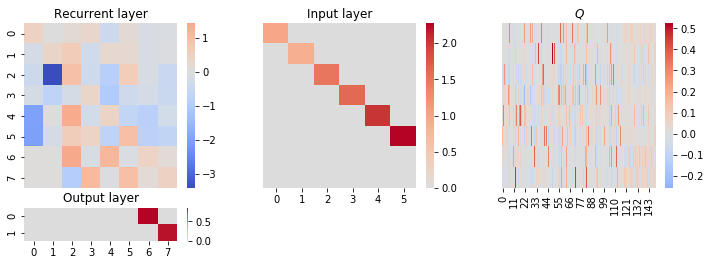

In [4]:
plot_latent_parameters(LCA(), "mrhq0Ftn")

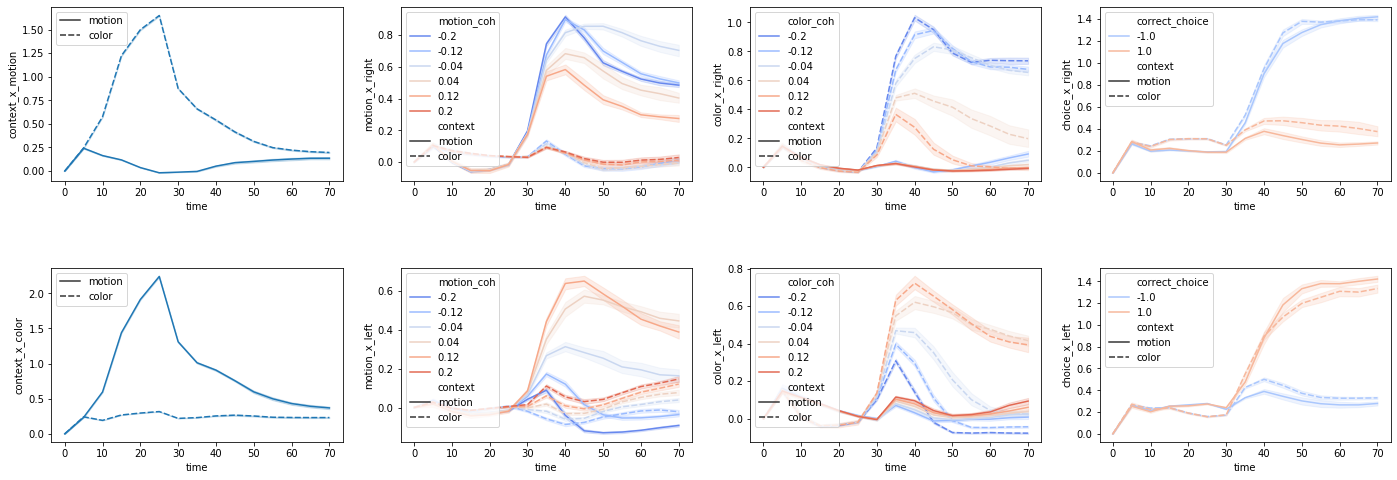

In [3]:
plot_figure_four(LCA() & 'lca_id="mrhq0Ftn"',Trial() & 'model_id="6rV5JuQH"')

# Figure Five
* Perturbations to confirm populations are behaviorally relevant.

In [25]:
ModelPerturbation()

*model_id    *perturbation_ direction     strength    
+----------+ +------------+ +-----------+ +----------+
6rV5JuQH     4MC            2             0.100       
6rV5JuQH     6AZ            0             -0.100      
6rV5JuQH     9Gf            2             0.250       
6rV5JuQH     fGu            0             -0.500      
6rV5JuQH     K7G            0             0.000       
6rV5JuQH     ZnB            0             -0.250      
 (Total: 6)

In [27]:
def plot_figure_five(trial_table,title):
    z = trial_table.fetch('output')
    motion_coh = trial_table.fetch('motion_coh')
    color_coh = trial_table.fetch('color_coh')
    context = trial_table.fetch('context')

    id_df = pd.DataFrame([])
    for i in range(900):
            data = {'motion_coh': motion_coh[i],
                    'color_coh': color_coh[i],
                    'choice': np.maximum(np.sign(z[i][-1,1] - z[i][-1,0]),0),
                    'context': context[i]}

            data = pd.DataFrame(data.items())
            data = data.transpose()
            data.columns = data.iloc[0]
            data = data.drop(data.index[[0]])
            id_df = id_df.append(data)
    motion_df = id_df[id_df['context']=="motion"]
    color_df = id_df[id_df['context']=="color"]

    motion_df = motion_df.groupby(['motion_coh', 'color_coh'])
    color_df = color_df.groupby(['motion_coh', 'color_coh'])
    motion_df = ((motion_df['choice'].apply(np.mean))).reset_index()
    color_df = ((color_df['choice'].apply(np.mean))).reset_index()

    plt.figure(figsize=(12,4))
    plt.subplot(1,2,1)
    sns.heatmap(motion_df.pivot(index='motion_coh', columns='color_coh', values='choice'), annot=True,vmin=0.5, vmax=1)
    plt.title('Motion context')

    plt.subplot(1,2,2)
    sns.heatmap(color_df.pivot(index='motion_coh', columns='color_coh', values='choice'), annot=True,vmin=0.5, vmax=1)
    plt.title('Color context')
    plt.suptitle(title)



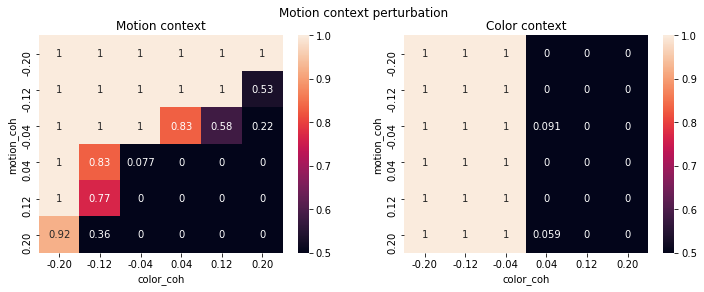

In [29]:
plot_figure_five(PerturbationTrial() & 'perturbation_id="ZnB"', 'Motion context perturbation')

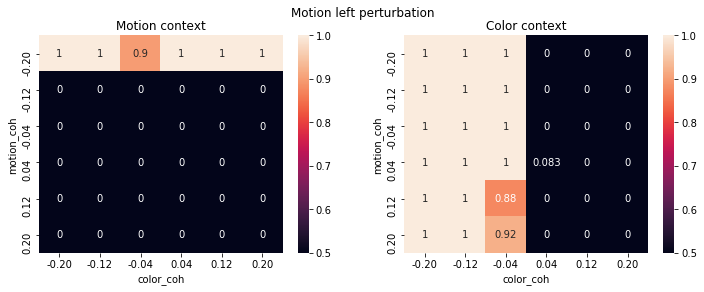

In [31]:
plot_figure_five(PerturbationTrial() & 'perturbation_id="9Gf"', 'Motion left perturbation')

# Figure Six
* Interpretation of latent circuit
    * What is Q?
        * Plotting the matrix $Q^TW_\text{ext}$ shows that $Q\sim W_\text{ext}$
    * Invariance of $Col(Q)$

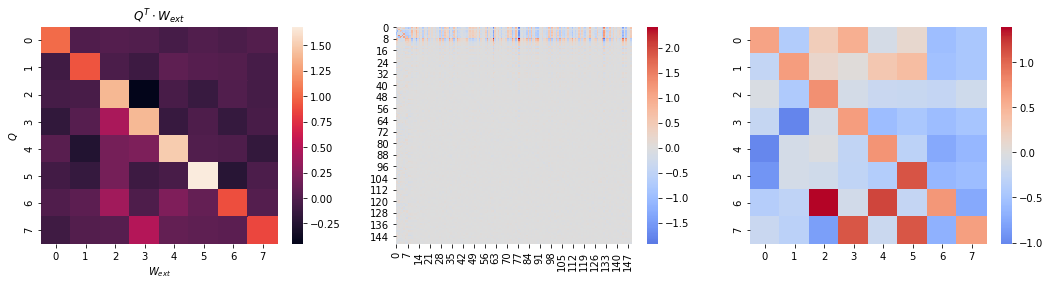

In [62]:
plt.figure(figsize=(18,4))
plt.subplot(1,3,1)
lca_table = LCA() & 'lca_id="mrhq0Ftn"'
model_table = Model() & 'model_id="6rV5JuQH"'
q = lca_table.fetch1('q')
w_in = model_table.fetch1('w_in')
w_out = model_table.fetch1('w_out')
w_ext = np.concatenate((w_in,w_out.T),axis=1)

sns.heatmap(q @ w_ext )
plt.xlabel(r'$W_{ext}$')
plt.ylabel(r'$Q$')
plt.title(r'$Q^T\cdot W_{ext}$')

plt.subplot(1,3,2)
Q = np.random.rand(150,150)
q = lca_table.fetch1('q')
Q[:8,:]=q
Q=Q.T
Q, _ = np.linalg.qr(Q)
Q[:,:8]= q.T
w_rec = model_table.fetch1('w_rec')
sns.heatmap((Q.T @ w_rec @ Q), center=0,cmap='coolwarm')

plt.subplot(1,3,3)
sns.heatmap((Q.T @ w_rec @ Q)[:8,:8], center=0,cmap='coolwarm')

# Figure Seven

In [9]:
df = pd.DataFrame((Model() & 'connectivity="large"').proj('model_id', 'connectivity','lr','r2','l2_task').fetch())
df.sort_values(by=['l2_task'],ascending=True).head(5)

model_id connectivity        lr        r2   l2_task
0  6rV5JuQH        large  0.001000  0.961561  0.006008

# Supplementary Figure One

(270000, 8)
(270000, 8)


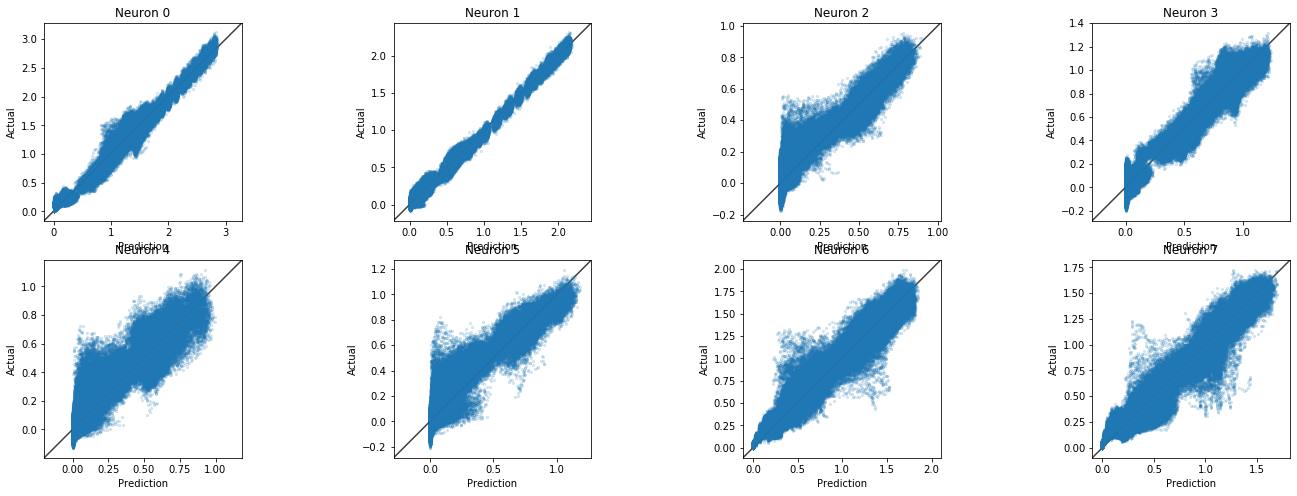

In [6]:
plot_prediction_actual(Model(),LCA(), LCATrial(),Trial(), "WhNYnalp","1p3mbmqu")

In [11]:
Trial()

*model_id    *trial_id    context     motion_coh     color_coh     correct_choice input      hidden     output     score     
+----------+ +----------+ +---------+ +------------+ +-----------+ +------------+ +--------+ +--------+ +--------+ +--------+
6rV5JuQH     0            color       -0.12          0.12          1              =BLOB=     =BLOB=     =BLOB=     0.9716    
6rV5JuQH     1            color       -0.20          0.12          1              =BLOB=     =BLOB=     =BLOB=     0.9794    
6rV5JuQH     2            color       0.12           0.12          1              =BLOB=     =BLOB=     =BLOB=     0.9746    
6rV5JuQH     3            motion      -0.04          -0.04         -1             =BLOB=     =BLOB=     =BLOB=     0.9442    
6rV5JuQH     4            color       -0.20          0.04          1              =BLOB=     =BLOB=     =BLOB=     0.9681    
6rV5JuQH     5            motion      -0.12          0.12          -1             =BLOB=     =BLOB=     =BLOB=     0.9780    
6rV5JuQH     6            color       -0.04          -0.20         -1             =BLOB=     =BLOB=     =BLOB=     0.9855    
6rV5JuQH     7            motion      0.12           -0.20         1              =BLOB=     =BLOB=     =BLOB=     0.9776    
6rV5JuQH     8            color       -0.04          -0.04         -1             =BLOB=     =BLOB=     =BLOB=     0.9778    
6rV5JuQH     9            motion      0.20           0.04          1              =BLOB=     =BLOB=     =BLOB=     0.9751    
6rV5JuQH     10           color       0.20           -0.20         -1             =BLOB=     =BLOB=     =BLOB=     0.9804    
6rV5JuQH     11           motion      -0.04          -0.20         -1             =BLOB=     =BLOB=     =BLOB=     0.7275    
6rV5JuQH     12           motion      0.04           -0.20         1              =BLOB=     =BLOB=     =BLOB=     0.9819    
6rV5JuQH     13           motion      0.12           0.20          1              =BLOB=     =BLOB=     =BLOB=     0.9751    
6rV5JuQH     14           color       -0.12          0.20          1              =BLOB=     =BLOB=     =BLOB=     0.9735    
6rV5JuQH     15           motion      0.20           0.12          1              =BLOB=     =BLOB=     =BLOB=     0.9797    
6rV5JuQH     16           color       -0.20          -0.20         -1             =BLOB=     =BLOB=     =BLOB=     0.9786    
6rV5JuQH     17           motion      0.12           0.20          1              =BLOB=     =BLOB=     =BLOB=     0.9800    
6rV5JuQH     18           color       -0.12          0.20          1              =BLOB=     =BLOB=     =BLOB=     0.9826    
6rV5JuQH     19           color       0.12           -0.12         -1             =BLOB=     =BLOB=     =BLOB=     0.9818    
6rV5JuQH     20           motion      0.04           0.20          1              =BLOB=     =BLOB=     =BLOB=     0.9786    
6rV5JuQH     21           color       0.20           0.20          1              =BLOB=     =BLOB=     =BLOB=     0.9818    
6rV5JuQH     22           motion      -0.04          0.12          -1             =BLOB=     =BLOB=     =BLOB=     0.9624    
6rV5JuQH     23           color       -0.20          0.20          1              =BLOB=     =BLOB=     =BLOB=     0.9785    
6rV5JuQH     24           color       -0.20          0.04          1              =BLOB=     =BLOB=     =BLOB=     0.0922    
6rV5JuQH     25           motion      0.04           0.20          1              =BLOB=     =BLOB=     =BLOB=     0.9811    
6rV5JuQH     26           color       -0.20          -0.04         -1             =BLOB=     =BLOB=     =BLOB=     0.9717    
6rV5JuQH     27           color       0.12           -0.12         -1             =BLOB=     =BLOB=     =BLOB=     0.9777    
6rV5JuQH     28           motion      -0.12          -0.20         -1             =BLOB=     =BLOB=     =BLOB=     0.9674    
6rV5JuQH     29           motion      -0.20          0.04          -1             =BLOB=     =

In [4]:
LCA()

*model_id    *lca_id      lr            max_epochs     valid_loss     valid_loss train_loss w_rec      w_in       w_out      q          w_error     q_error    
+----------+ +----------+ +-----------+ +------------+ +------------+ +--------+ +--------+ +--------+ +--------+ +--------+ +--------+ +---------+ +---------+
6rV5JuQH     06vEJo2n     0.0010000     3000           0.0866         =BLOB=     =BLOB=     =BLOB=     =BLOB=     =BLOB=     =BLOB=     nan         nan        
6rV5JuQH     1c108cP1     0.0010000     3000           0.1040         =BLOB=     =BLOB=     =BLOB=     =BLOB=     =BLOB=     =BLOB=     nan         nan        
6rV5JuQH     218638vJ     0.0010000     3000           0.0994         =BLOB=     =BLOB=     =BLOB=     =BLOB=     =BLOB=     =BLOB=     nan         nan        
6rV5JuQH     2awGxsKX     0.0010000     3000           0.5915         =BLOB=     =BLOB=     =BLOB=     =BLOB=     =BLOB=     =BLOB=     nan         nan        
6rV5JuQH     2mGWdRT0     0.0010000     3000           0.0797         =BLOB=     =BLOB=     =BLOB=     =BLOB=     =BLOB=     =BLOB=     nan         nan        
6rV5JuQH     3J2z8jtl     0.0010000     3000           0.0826         =BLOB=     =BLOB=     =BLOB=     =BLOB=     =BLOB=     =BLOB=     nan         nan        
6rV5JuQH     4CtJVhio     0.0010000     3000           0.0969         =BLOB=     =BLOB=     =BLOB=     =BLOB=     =BLOB=     =BLOB=     nan         nan        
6rV5JuQH     4PAvEFUe     0.0010000     3000           0.1077         =BLOB=     =BLOB=     =BLOB=     =BLOB=     =BLOB=     =BLOB=     nan         nan        
6rV5JuQH     4xAQSlBE     0.0010000     3000           0.1023         =BLOB=     =BLOB=     =BLOB=     =BLOB=     =BLOB=     =BLOB=     nan         nan        
6rV5JuQH     60D9EK3q     0.0010000     3000           0.1023         =BLOB=     =BLOB=     =BLOB=     =BLOB=     =BLOB=     =BLOB=     nan         nan        
6rV5JuQH     62QrWbVZ     0.0010000     3000           0.0925         =BLOB=     =BLOB=     =BLOB=     =BLOB=     =BLOB=     =BLOB=     nan         nan        
6rV5JuQH     6Cx5jnIh     0.0010000     3000           0.1199         =BLOB=     =BLOB=     =BLOB=     =BLOB=     =BLOB=     =BLOB=     nan         nan        
6rV5JuQH     6HoUfGb9     0.0010000     3000           0.1019         =BLOB=     =BLOB=     =BLOB=     =BLOB=     =BLOB=     =BLOB=     nan         nan        
6rV5JuQH     6kz03Y8O     0.0010000     3000           0.0877         =BLOB=     =BLOB=     =BLOB=     =BLOB=     =BLOB=     =BLOB=     nan         nan        
6rV5JuQH     6PYfSKK1     0.0010000     3000           0.5913         =BLOB=     =BLOB=     =BLOB=     =BLOB=     =BLOB=     =BLOB=     nan         nan        
6rV5JuQH     6qk8I9yZ     0.0010000     3000           0.1001         =BLOB=     =BLOB=     =BLOB=     =BLOB=     =BLOB=     =BLOB=     nan         nan        
6rV5JuQH     7p7O1tRl     0.0010000     3000           0.1064         =BLOB=     =BLOB=     =BLOB=     =BLOB=     =BLOB=     =BLOB=     nan         nan        
6rV5JuQH     7Qg2em3M     0.0010000     3000           0.1212         =BLOB=     =BLOB=     =BLOB=     =BLOB=     =BLOB=     =BLOB=     nan         nan        
6rV5JuQH     8eq5xOBo     0.0010000     3000           0.0978         =BLOB=     =BLOB=     =BLOB=     =BLOB=     =BLOB=     =BLOB=     nan         nan        
6rV5JuQH     8UF1iCaN     0.0010000     3000           0.1049         =BLOB=     =BLOB=     =BLOB=     =BLOB=     =BLOB=     =BLOB=     nan         nan        
6rV5JuQH     9IZkYFHj     0.0010000     3000           0.0751         =BLOB=     =BLOB=     =BLOB=     =BLOB=     =BLOB=     =BLOB=     nan         nan        
6rV5JuQH     9xekQgNp     0.0010000     3000           0.1088         =BLOB=     =BLOB=     =BLOB=     =BLOB=     =BLOB=     =BLOB=     nan         nan        
6rV5JuQH     A4AALYMV     0.0010000     3000           0.1086         =BLOB=     =BLOB=     =BLOB=     =BLOB=     =BLOB=     =BLOB=     nan         nan        
